In [1]:
import kagglehub
path = kagglehub.dataset_download("mohammedabdeldayem/the-fake-or-real-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-fake-or-real-dataset


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Large
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import random
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

2025-07-13 20:17:08.968218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752437829.138759      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752437829.187208      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data preprocessing

In [3]:
def filter_broken_files(files, labels):
    good_files = []
    good_labels = []
    for file, label in zip(files, labels):
        try:
            _ = librosa.load(file, sr = 16000, mono = True)
            good_files.append(file)
            good_labels.append(label)

        except Exception as ex:
            print(f"Broken file skipped {file}: {ex}")

    return np.array(good_files), np.array(good_labels)

def get_files_labels(real_path, fake_path, extensions = (".wav", ".mp3")):
    real_files = []
    fake_files = []

    for ext in extensions:
        real_files.extend(tf.io.gfile.glob(os.path.join(real_path, f"*{ext}")))
        fake_files.extend(tf.io.gfile.glob(os.path.join(fake_path, f"*{ext}")))

    real_labels = [1] * len(real_files)
    fake_labels = [0] * len(fake_files)

    all_files = real_files + fake_files
    all_labels = real_labels + fake_labels

    return np.array(all_files), np.array(all_labels)

In [4]:
train_path = "/kaggle/input/the-fake-or-real-dataset/for-original/for-original/training"
test_path = "/kaggle/input/the-fake-or-real-dataset/for-original/for-original/testing"
val_path = "/kaggle/input/the-fake-or-real-dataset/for-original/for-original/validation"

files_train, labels_train = get_files_labels(os.path.join(train_path, "real"), os.path.join(train_path, "fake"))
files_val, labels_val = get_files_labels(os.path.join(val_path, "real"), os.path.join(val_path, "fake"))
files_test, labels_test = get_files_labels(os.path.join(test_path, "real"), os.path.join(test_path, "fake"))

files_train_filtered, labels_train_filtered = filter_broken_files(files_train, labels_train)
files_val_filtered, labels_val_filtered = filter_broken_files(files_val, labels_val)
files_test_filtered, labels_test_filtered = filter_broken_files(files_test, labels_test)

train_ds = tf.data.Dataset.from_tensor_slices((files_train_filtered, labels_train_filtered))
val_ds = tf.data.Dataset.from_tensor_slices((files_val_filtered, labels_val_filtered))
test_ds = tf.data.Dataset.from_tensor_slices((files_test_filtered, labels_test_filtered))

/tmp/ipykernel_19/674761242.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  _ = librosa.load(file, sr = 16000, mono = True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file17407.mp3: 


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 50.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file19851.mp3: 


/tmp/ipykernel_19/674761242.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  _ = librosa.load(file, sr = 16000, mono = True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file5323.mp3: 


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 50.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file31017.mp3: 


/tmp/ipykernel_19/674761242.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  _ = librosa.load(file, sr = 16000, mono = True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file32972.mp3: 
Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file27839.mp3: 


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 50.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file16643.mp3: 


/tmp/ipykernel_19/674761242.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  _ = librosa.load(file, sr = 16000, mono = True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file27643.mp3: 
Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file9875.mp3: 
Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file13424.mp3: 
Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file27206.mp3: 
Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file15746.mp3: 
Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file17450.mp3: 
Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file30959.mp3: 
Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-original/validation/fake/file31606.mp3: 
Broken file skipped /kaggle/input/the-fake-or-real-dataset/for-original/for-ori

I0000 00:00:1752438472.062466      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752438472.063143      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
def load_wav(filename):
    ext = os.path.splitext(filename)[-1].lower()
    if ext not in [".wav", ".mp3"]:
        raise ValueError(f"Unsupported file format: {ext}")
    
    wav, sample_rate = librosa.load(filename, sr = 16000, mono = True)
    return wav, sample_rate

def preprocess_audio(file_path, label, mode='train'):
    if isinstance(file_path, tf.Tensor):
        file_path = file_path.numpy().decode('utf-8')

    wav, sample_rate = load_wav(file_path)
    target_length = 48000

    if len(wav) < target_length:
        pad_total = target_length - len(wav)
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        wav = np.pad(wav, (pad_left, pad_right))
    else:
        start = random.randint(0, len(wav) - target_length) if mode == 'train' else (len(wav) - target_length) // 2
        wav = wav[start:start + target_length]

    spectrogram = librosa.feature.melspectrogram(y=wav, sr=16000, n_fft=1024, hop_length=512, n_mels=128)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max, top_db=80.0)
    spectrogram_db = (spectrogram_db + 80) / 80
    spectrogram_db = tf.expand_dims(spectrogram_db, axis=-1)
    spectrogram_db = tf.cast(spectrogram_db, tf.float32)
    label = tf.cast(label, tf.int32)

    return spectrogram_db, label

def train_preprocess_wrapper(file_path, label):
    spectrogram, label = tf.py_function(preprocess_audio, [file_path, label, 'train'], [tf.float32, tf.int32])
    spectrogram.set_shape([None, None, 1])
    label.set_shape([])
    return spectrogram, label

def val_test_preprocess_wrapper(file_path, label):
    spectrogram, label = tf.py_function(preprocess_audio, [file_path, label, 'val_test'], [tf.float32, tf.int32])
    spectrogram.set_shape([None, None, 1])
    label.set_shape([])
    return spectrogram, label

In [6]:
def create_dataset(dataset, batch_size=32, shuffle=True, mode='train'):
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)

    if(mode=='train'):
      dataset = dataset.map(train_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    else:
      dataset = dataset.map(val_test_preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [7]:
train_ds = create_dataset(train_ds, batch_size=32, shuffle=True, mode='train')
val_ds = create_dataset(val_ds, batch_size=32, shuffle=False, mode='val')
test_ds = create_dataset(test_ds, batch_size=32, shuffle=False, mode='test')

# Visualize Mel-spectrogram

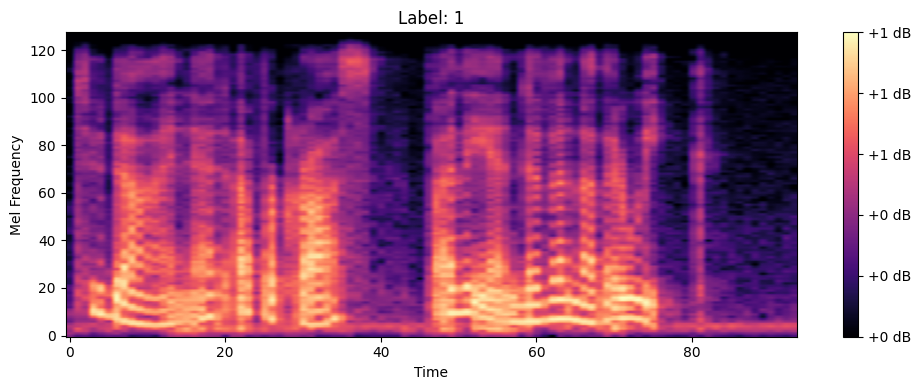

In [8]:
for spectrograms, labels in train_ds.take(1):
    idx = np.random.randint(0, spectrograms.shape[0])

    spec = spectrograms[idx].numpy().squeeze()
    label = labels.numpy()[idx]

    plt.figure(figsize=(10, 4))
    plt.imshow(spec, aspect='auto', origin='lower', cmap='magma')
    plt.title(f"Label: {label}")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [9]:
samples, labels = train_ds.as_numpy_iterator().next()
print(samples.shape)
input_shape = samples.shape[1::]
print(input_shape)

(32, 128, 94, 1)
(128, 94, 1)


# Build and Train Model

In [10]:
def preprocess_mel_spectrogram(mel_spectrogram):
    mel_spectrogram = tf.image.resize(mel_spectrogram, (224, 224))
    mel_spectrogram = tf.repeat(mel_spectrogram, 3, axis = -1)
    return mel_spectrogram

In [11]:
def SpectraNet(input_shape=(128, 94, 1)):
    backbone = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
    backbone.trainable = False

    inputs = layers.Input(shape = input_shape)
    x = layers.Lambda(preprocess_mel_spectrogram)(inputs)

    x = backbone(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)

    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs = inputs, outputs = outputs)
    return model

In [12]:
modelSpectraNet = SpectraNet()

modelSpectraNet.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(filepath = "SpectraNet.weights.h5", monitor = 'val_loss', save_best_only = True,
                                            save_weights_only = True, mode = 'min', verbose = 1)

reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', facor = 0.5, patience = 5, min_lr = 1e-6, verbose = 1)

early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

callbacks = [checkpoint, reduce_lr_on_plateau, early_stopping]

modelSpectraNet_history = modelSpectraNet.fit(train_ds, validation_data = val_ds, epochs = 20, callbacks = callbacks)

modelSpectraNet.save('/kaggle/working/SpectraNet.keras')
with open('/kaggle/working/SpectraNet.pkl', 'wb') as f:
    pickle.dump(modelSpectraNet_history.history, f)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


I0000 00:00:1752438488.780215     146 service.cc:148] XLA service 0x7aad28011980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752438488.781205     146 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752438488.781225     146 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752438491.008796     146 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1684 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.4427 - loss: 1.1030   

I0000 00:00:1752438497.836441     146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1684/1684 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9153 - loss: 0.2618
Epoch 1: val_loss improved from inf to 2.02676, saving model to SpectraNet.weights.h5
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 953s 554ms/step - accuracy: 0.9153 - loss: 0.2618 - val_accuracy: 0.5870 - val_loss: 2.0268 - learning_rate: 0.0010
Epoch 2/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8867 - loss: 0.3931
Epoch 2: val_loss did not improve from 2.02676
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 914s 543ms/step - accuracy: 0.8867 - loss: 0.3930 - val_accuracy: 0.5007 - val_loss: 3.0175 - learning_rate: 0.0010
Epoch 3/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9092 - loss: 0.3272
Epoch 3: val_loss did not improve from 2.02676
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 909s 540ms/step - accuracy: 0.9092 - loss: 0.3271 - val_accuracy: 0.6789 - val_loss: 2.0755 - learning_rate: 0.0010
Epoch 4/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9133 - loss: 0.3152
Epoch 4: val_loss improved fro

In [13]:
# SpectraNet.load_weights("/kaggle/input/spectranet/other/default/1/SpectraNet/SpectraNet.weights.h5")
# with open('/kaggle/input/spectranet/other/default/1/SpectraNet/SpectraNet.pkl', 'rb') as f:
#     SpectraNet_history = pickle.load(f)

# Visualize training metrics

In [14]:
def plotResults(history, model_name = 'Model'):
    metrics = ['accuracy', 'loss']
    val_metrics = ['val_accuracy', 'val_loss']

    epochs = range(1, len(history['loss']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(25, 5))

    for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
        ax = axes[i]
        ax.plot(epochs, history[metric], label=f'Train {metric}')
        ax.plot(epochs, history[val_metric], label=f'Val {metric}')
        ax.set_title(metric)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric)
        ax.legend()

    plt.suptitle(model_name, fontsize = 16)
    plt.tight_layout()
    plt.show()

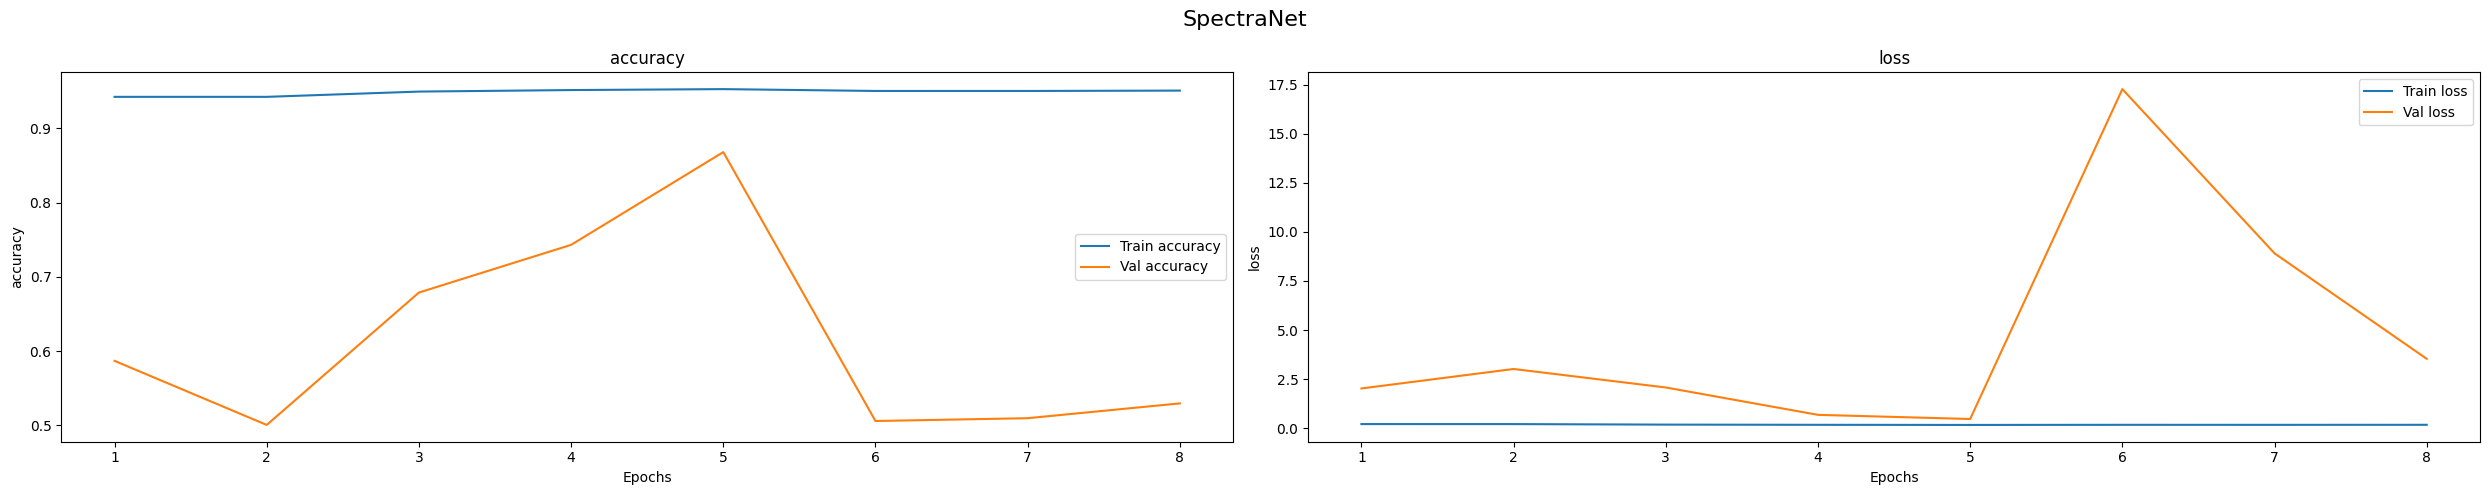

In [15]:
plotResults(modelSpectraNet_history.history, model_name = 'SpectraNet')

# Evaluation

In [16]:
evaluation = modelSpectraNet.evaluate(test_ds)
predicted = modelSpectraNet.predict(test_ds)
predicted_labels = (predicted > 0.5).astype(int).flatten()
grouth_true_labels = np.concatenate([y for x, y in test_ds], axis = 0)

accuracy = metrics.accuracy_score(grouth_true_labels, predicted_labels)
precision = metrics.precision_score(grouth_true_labels, predicted_labels, average = 'weighted')
f1 = metrics.f1_score(grouth_true_labels, predicted_labels, average = 'weighted')
recall = metrics.recall_score(grouth_true_labels, predicted_labels, average = 'weighted')
roc_auc = metrics.roc_auc_score(grouth_true_labels, predicted_labels, average = 'weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1: {f1}")
print(f"Recall: {recall}")
print(f"ROC_AUC: {roc_auc}")

145/145 ━━━━━━━━━━━━━━━━━━━━ 74s 512ms/step - accuracy: 0.4089 - loss: 2.6960
145/145 ━━━━━━━━━━━━━━━━━━━━ 78s 500ms/step
Accuracy: 0.6454466983167889
Precision: 0.747842707920673
F1: 0.5999119453877484
Recall: 0.6454466983167889
ROC_AUC: 0.6378281969852843


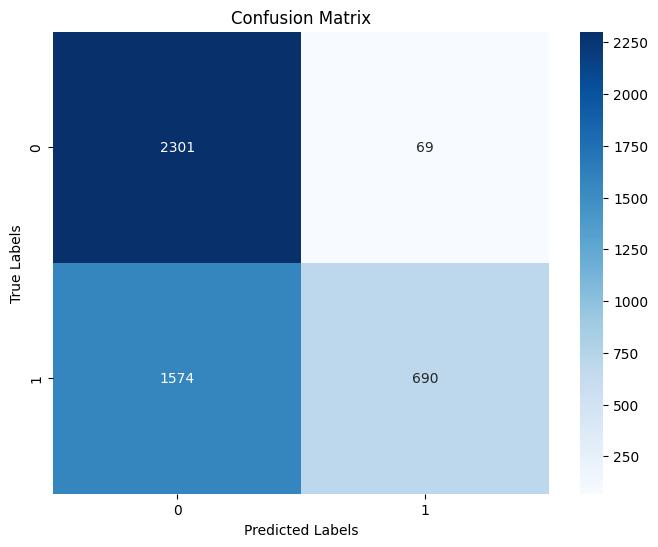

In [17]:
confusion_matrix = metrics.confusion_matrix(grouth_true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Inference

In [18]:
def inference(model, file_path):
    wav, sr = load_wav(file_path)
    target_length = 48000
    
    if len(wav) < target_length:
        pad_total = target_length - len(wav)
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        wav = np.pad(wav, (pad_left, pad_right))
    else:
        start = random.randint(0, (len(wav) - target_length) // 2)
        wav = wav[start:start + target_length]
            
    spectrogram = librosa.feature.melspectrogram(y = wav, sr = 16000, n_fft = 1024, hop_length = 512, n_mels = 128)
    spectrogram_db = librosa.power_to_db(spectrogram, ref = np.max, top_db = 80.0)
    spectrogram_db = (spectrogram_db + 80) / 80
    spectrogram_db = tf.expand_dims(spectrogram_db, axis  = -1)
    spectrogram_db = tf.cast(spectrogram_db, tf.float32)
    spectrogram_db = tf.expand_dims(spectrogram_db, axis=0)
        
    pred = model(spectrogram_db, training = False)
    predicted_label = tf.cast(pred > 0.5, tf.int32).numpy().flatten()[0]
    
    return f"Final prediction: {'Fake' if predicted_label == 0 else 'Real'}"

In [19]:
file_path = "/kaggle/input/the-fake-or-real-dataset/for-original/for-original/training/fake/file10021.mp3"
inference(modelSpectraNet, file_path)

'Final prediction: Fake'